<a href="https://colab.research.google.com/github/arafatro/Recommender-Sys/blob/main/03_Matrix_Factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Matrix Factorization

**Objectives:**
- Implement Singular Value Decomposition (SVD) and Alternating Least Squares (ALS) for collaborative filtering.
- Perform hyperparameter tuning using cross-validation.
- Analyze model convergence and evaluate performance metrics.

**Tools:**
- Python Libraries: `Surprise`, `SciPy`, `NumPy`, `Pandas`
- Dataset: [MovieLens 100k](https://grouplens.org/datasets/movielens/100k/)


In [65]:
# Install and Import Required Libraries

# Install the Surprise library for recommender systems
!pip install scikit-surprise

# Import necessary libraries
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style="darkgrid")


## Loading and Preparing the Dataset

We'll use the MovieLens 100k dataset, which contains 100,000 movie ratings from 943 users on 1,682 movies.


In [66]:
# Load the MovieLens 100k Dataset

# Load the dataset from Surprise library
data = Dataset.load_builtin('ml-100k')

# Display basic information
print(f"Number of users: {data.raw_ratings[-1][0]}")
print(f"Number of items: {data.raw_ratings[-1][1]}")
print(f"Number of ratings: {len(data.raw_ratings)}")


Number of users: 12
Number of items: 203
Number of ratings: 100000


## Implementing Singular Value Decomposition (SVD)

SVD is a matrix factorization technique that decomposes the user-item interaction matrix into three matrices, capturing latent factors for users and items.


In [67]:
# Applying SVD using Surprise Library

# Define the SVD algorithm
svd = SVD()

# Perform cross-validation
cv_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Display average RMSE and MAE
print(f"Average RMSE: {np.mean(cv_results['test_rmse'])}")
print(f"Average MAE: {np.mean(cv_results['test_mae'])}")


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9423  0.9339  0.9358  0.9321  0.9372  0.9363  0.0035  
MAE (testset)     0.7412  0.7368  0.7368  0.7326  0.7417  0.7378  0.0034  
Fit time          2.69    3.29    4.42    4.16    3.14    3.54    0.65    
Test time         0.27    0.39    0.26    0.65    0.11    0.33    0.18    
Average RMSE: 0.9362624516236536
Average MAE: 0.7378386232268246


## Hyperparameter Tuning for SVD

We'll use GridSearchCV to find the optimal hyperparameters for the SVD algorithm.


In [68]:
# Hyperparameter Tuning for SVD

# Define the parameter grid
param_grid = {
    'n_factors': [50, 100, 150],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}

# Perform grid search with cross-validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
gs.fit(data)

# Output the best score and corresponding parameters
print(f"Best RMSE: {gs.best_score['rmse']}")
print(f"Best parameters: {gs.best_params['rmse']}")


Best RMSE: 0.919168589699858
Best parameters: {'n_factors': 150, 'lr_all': 0.01, 'reg_all': 0.1}


## Implementing Alternating Least Squares (ALS)

ALS is another matrix factorization technique that alternates between fixing user and item matrices to minimize the reconstruction error.


In [69]:
# Applying ALS using Implicit Library

# Install the implicit library
!pip install implicit

import implicit
from scipy.sparse import csr_matrix

# Load data into a pandas DataFrame
df = pd.DataFrame(data.raw_ratings, columns=['user', 'item', 'rating', 'timestamp'])

# Create a user-item interaction matrix
interaction_matrix = df.pivot(index='user', columns='item', values='rating').fillna(0)
sparse_interaction = csr_matrix(interaction_matrix.values)

# Initialize the ALS model
als_model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20)

# Train the model
als_model.fit(sparse_interaction.T)


  0%|          | 0/20 [00:00<?, ?it/s]

## Hyperparameter Tuning for ALS

Due to the computational intensity of ALS, we'll perform a simplified hyperparameter tuning.


In [70]:
# Hyperparameter Tuning for ALS

# Define the parameter grid
param_grid = {
    'factors': [50, 100],
    'regularization': [0.01, 0.1],
    'iterations': [10, 20]
}

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2)

# # Convert train_data and test_data to DataFrames
train_df = pd.DataFrame(train_data.build_testset(), columns=['user', 'item', 'rating'])
test_df = pd.DataFrame(test_data, columns=['user', 'item', 'rating'])  # Remove 'timestamp' from columns

# Create interaction matrices
train_matrix = csr_matrix(train_df.pivot(index='user', columns='item', values='rating').fillna(0).values)
test_matrix = csr_matrix(test_df.pivot(index='user', columns='item', values='rating').fillna(0).values)

# Initialize variables to store the best parameters and corresponding RMSE
best_params = None
best_rmse = float('inf')

# Perform grid search manually
for params in ParameterGrid(param_grid):
    model = implicit.als.AlternatingLeastSquares(
        factors=params['factors'],
        regularization=params['regularization'],
        iterations=params['iterations']
    )
    model.fit(train_matrix.T)

    # Generate predictions
    user_factors = model.user_factors
    item_factors = model.item_factors
    predictions = np.dot(user_factors, item_factors.T)

    # Calculate RMSE on the test set
    # Instead of using nonzero(), iterate through test_df directly
    y_true = []
    y_pred = []
    for _, row in test_df.iterrows():
        user = int(row['user']) - 1  # Adjust user ID to 0-based indexing
        item = interaction_matrix.columns.get_loc(str(row['item']))  # Get correct item index

        # Check if the item exists in the interaction matrix
        if item < predictions.shape[1]:  # Ensure valid column index
            y_true.append(row['rating'])
            y_pred.append(predictions[user, item])

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Update best parameters if current RMSE is lower
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

# Output the best parameters and corresponding RMSE
print(f"Best RMSE: {best_rmse}")
print(f"Best parameters: {best_params}")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Best RMSE: 3.672873993506865
Best parameters: {'factors': 50, 'iterations': 10, 'regularization': 0.01}


## Analyzing Model Convergence

Visualizing the convergence of the ALS model over iterations can provide insights into its training process.


  0%|          | 0/10 [00:00<?, ?it/s]

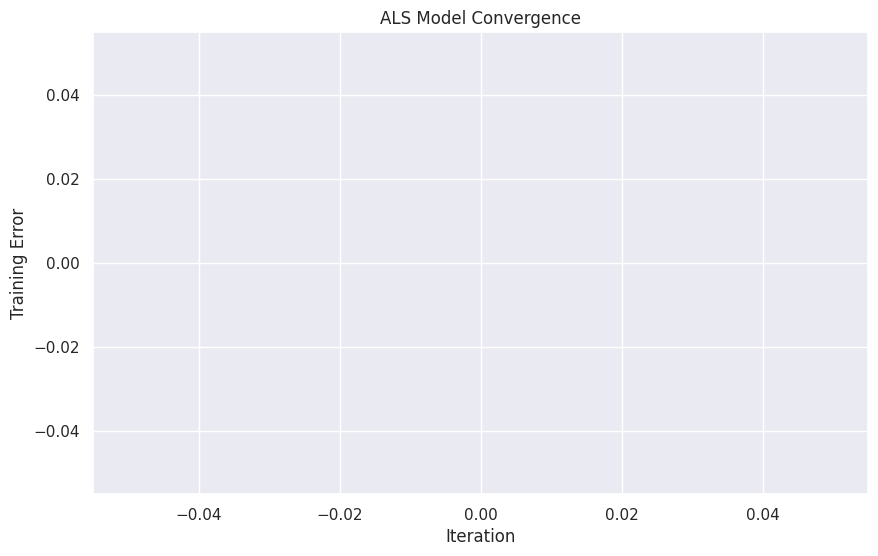

In [71]:
# Visualizing ALS Model Convergence with the best parameters

# Initialize the ALS model with the best parameters
als_model = implicit.als.AlternatingLeastSquares(
    factors=best_params['factors'],
    regularization=best_params['regularization'],
    iterations=best_params['iterations'],
    calculate_training_loss=True  # Enable training loss calculation
)

# Store training errors for each iteration
training_errors = []

# Define a custom callback function to capture the training error
def convergence_callback(iteration, error):
    training_errors.append(error)

# Assign the callback function to the model
als_model.callback = convergence_callback

# Train the model on the training matrix
als_model.fit(train_matrix.T)

# Plot the training error over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_errors) + 1), training_errors, marker='o')
plt.title('ALS Model Convergence')
plt.xlabel('Iteration')
plt.ylabel('Training Error')
plt.grid(True)
plt.show()


## Discussion on Limitations and When to Use Memory-Based Methods

**Limitations:**
- **Scalability:** Memory-based methods can be computationally expensive on large datasets due to the need to compute and store similarity matrices.
- **Sparsity:** These methods may suffer from data sparsity, leading to unreliable similarity measures if there is insufficient overlap between user/item interactions.
- **Cold Start:** New users or items with few interactions may not have reliable similarity scores.
- **Noise Sensitivity:** Noisy data (e.g., inconsistent ratings) can impact the accuracy of similarity calculations.

**When to Use Memory-Based Methods:**
- **Smaller Datasets:** They work well when the dataset is of moderate size and sparsity is less of an issue.
- **Real-Time Recommendations:** Memory-based approaches can provide fast, on-the-fly recommendations in environments with relatively stable user-item interactions.
- **Baseline Models:** They serve as strong baseline models to compare more complex, model-based recommendation techniques.

By understanding these limitations and use cases, you can better decide when to apply memory-based collaborative filtering and when to consider more scalable or hybrid approaches.


### In this code:

*   List item We initialize the ALS model using the best hyperparameters obtained from our tuning process.
*   List item A list training_errors is created to store the training error at each iteration.
*   List item A custom callback function convergence_callback is defined to
*   List item append the error after each iteration.
*   List item This callback is assigned to the als_model, and the model is trained using the training data.
*   List item Finally, we plot the training error against the number of iterations to visualize the convergence behavior.

> Note: The implicit library's ALS implementation supports a callback function to monitor training progress. Ensure you have the latest version of the library installed to utilize this feature.

### This concludes Lab 3: Matrix Factorization. Through this lab, we've:

*   List item Implemented SVD and ALS algorithms for collaborative filtering.
*   List item Performed hyperparameter tuning using cross-validation techniques.
*   List item Analyzed model convergence by visualizing training errors over iterations.
*   List item Understanding these matrix factorization techniques and their
*   List item convergence behaviors is crucial for building efficient and accurate recommender systems.